In [2]:
import os, shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import optimizers
from keras.applications import InceptionResNetV2
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator

from PIL import ImageFile

In [3]:
# == SETUP ==
# Because the images are missing a block? https://stackoverflow.com/a/23575424/5473627
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# == VARIABLES ==
# Set the base as the path to the output of the zip file
base = './The Picnic Hackathon 2019/'
csv_path = base + 'train.tsv'

batch_size = 64 # 96 return ResourceExhaustError
output = './data/kfold/'
k = 5

In [5]:
# == INFO ==
# Print dataset information and metadata
df = pd.read_csv(csv_path, sep='\t')
print('df.head(): \n{}'.format(df.head()))
print('\ndf.describe(): \n{}'.format(df.describe()))

unique_labels = df['label'].unique()
print('\nunique_labels: \n{}'.format(unique_labels))
print('\nlen(unique_labels): {}'.format(len(unique_labels)))

np_train_data = df.values
print('\ndf.np_train_data(): \n{}'.format(np_train_data))

samples_in_fold = len(np_train_data) // k

df.head(): 
        file                    label
0  4080.jpeg  Minced meat & meatballs
1  2733.jpeg  Minced meat & meatballs
2  1336.jpeg  Minced meat & meatballs
3  2391.jpeg  Minced meat & meatballs
4  1312.jpeg  Minced meat & meatballs

df.describe(): 
            file                    label
count       7177                     7177
unique      7177                       25
top     4155.png  Bananas, apples & pears
freq           1                      850

unique_labels: 
['Minced meat & meatballs' 'Berries & cherries' 'Potatoes' 'Poultry'
 'Pre-baked breads' 'Pudding, yogurt & quark' 'Fresh bread' 'Cheese'
 'Kiwis, grapes & mango' 'Eggs' 'Onions, leek, garlic & beets'
 'Nectarines, peaches & apricots' 'Bananas, apples & pears'
 'Salad & cress' 'Fish' 'Milk' 'Citrus fruits'
 'Pineapples, melons & passion fruit' 'Fresh herbs' 'Lunch & Deli Meats'
 'Cucumber, tomatoes & avocados'
 'Asparagus, string beans & brussels sprouts'
 'Bell peppers, zucchinis & eggplants'
 'Broccoli, cauli

In [6]:
def create_dir(base_dir, dir_name):
    full_path = os.path.join(base_dir, dir_name)
    if not os.path.exists(full_path):
        os.mkdir(full_path)
    return full_path

def add_image_in_corresponding_labelled_folder(data, directory):
    for (name, label) in data:
        src = os.path.join(base, 'train/', name)
        dst = os.path.join(outputFold, directory, label, name)
        shutil.copyfile(src, dst)

In [7]:
# == SORTING DATA ==
# K-FOLD
create_dir(output, '')

print('samples_in_fold: {}'.format(samples_in_fold))
train_val_dirs = []
np.random.seed(0)
np.random.shuffle(np_train_data)

for fold in range(k):
    outputFold = output + str(fold)
    create_dir(outputFold, '')

    train_dir = create_dir(outputFold, 'train')
    validation_dir = create_dir(outputFold, 'validation')
    train_val_dirs.append((train_dir, validation_dir))

    for label in unique_labels:
        create_dir(train_dir, label)
        create_dir(validation_dir, label)

    IMAGES_SHOULD_BE_ADDED = False
    if (IMAGES_SHOULD_BE_ADDED):
        validation_data = np_train_data[samples_in_fold * fold:
                                          samples_in_fold * (fold + 1)] 
        training_data = np.concatenate((np_train_data[:samples_in_fold * fold], 
                                        np_train_data[samples_in_fold * (fold + 1):]))

        add_image_in_corresponding_labelled_folder(training_data, 'train')
        add_image_in_corresponding_labelled_folder(validation_data, 'validation')

samples_in_fold: 1435


In [8]:
# == CONFIGURE MODEL ==
conv_base = InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  pooling=False, # Check if setting this to avg or max does anything
                  input_shape=(299, 299, 3))

# Information about conv_base
# i = 0
# for layer in conv_base.layers:
#     print(str(i) + layer.name)
#     i = i + 1

#conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# layer 607 to 779 will be trainable.
# layer 267 to 779 will be trainable
# 607 is: conv2d_158 (Conv2D)             (None, 8, 8, 384)    884736      activation_157[0][0]

conv_base.trainable=True
for layer in conv_base.layers[:267]:
    #print(layer.name)
    layer.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(25, activation='sigmoid'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               50332160  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
___________________________

In [11]:
def plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

fold: 1
train_dir: /home/jupyter/kfold/1/train
val_dir: /home/jupyter/kfold/1/validation
Found 5742 images belonging to 25 classes.
Found 1435 images belonging to 25 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


89/89 [==============================] - 711s 8s/step - loss: 0.6559 - categorical_accuracy: 0.8236 - val_loss: 0.4423 - val_categorical_accuracy: 0.8658
Epoch 2/10
89/89 [==============================] - 409s 5s/step - loss: 0.6521 - categorical_accuracy: 0.8235 - val_loss: 0.4413 - val_categorical_accuracy: 0.8614
Epoch 3/10
89/89 [==============================] - 404s 5s/step - loss: 0.6478 - categorical_accuracy: 0.8252 - val_loss: 0.4164 - val_categorical_accuracy: 0.8709
Epoch 4/10
89/89 [==============================] - 401s 5s/step - loss: 0.6223 - categorical_accuracy: 0.8269 - val_loss: 0.4496 - val_categorical_accuracy: 0.8643
Epoch 5/10
89/89 [==============================] - 401s 5s/step - loss: 0.6462 - categorical_accuracy: 0.8276 - val_loss: 0.4343 - val_categorical_accuracy: 0.8680
Epoch 6/10
89/89 [==============================] - 404s 5s/step - loss: 0.5984 - categorical_accuracy: 0.8305 - val_loss: 0.4265 - val_categorical_accuracy: 0.8614
Epoch 7/10
89/89 [===

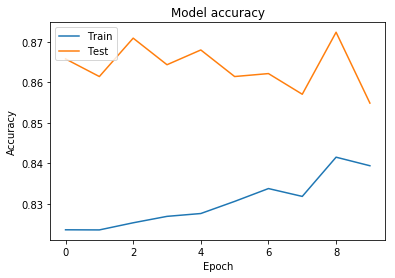

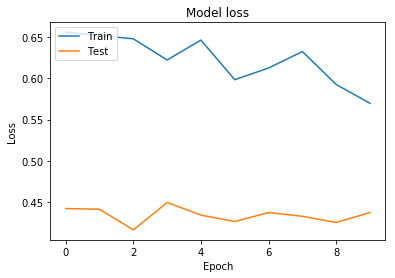

Saved model to disk
fold: 2
train_dir: /home/jupyter/kfold/2/train
val_dir: /home/jupyter/kfold/2/validation
Found 5742 images belonging to 25 classes.
Found 1435 images belonging to 25 classes.
Epoch 1/10
89/89 [==============================] - 700s 8s/step - loss: 0.5664 - categorical_accuracy: 0.8423 - val_loss: 0.4204 - val_categorical_accuracy: 0.8707
Epoch 2/10
89/89 [==============================] - 407s 5s/step - loss: 0.5825 - categorical_accuracy: 0.8366 - val_loss: 0.4281 - val_categorical_accuracy: 0.8738
Epoch 3/10
89/89 [==============================] - 406s 5s/step - loss: 0.5603 - categorical_accuracy: 0.8407 - val_loss: 0.4229 - val_categorical_accuracy: 0.8724
Epoch 4/10
89/89 [==============================] - 407s 5s/step - loss: 0.5779 - categorical_accuracy: 0.8431 - val_loss: 0.4175 - val_categorical_accuracy: 0.8731
Epoch 5/10
89/89 [==============================] - 407s 5s/step - loss: 0.5646 - categorical_accuracy: 0.8391 - val_loss: 0.4443 - val_categoric

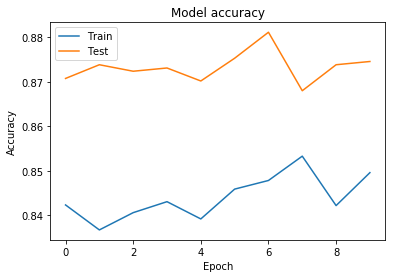

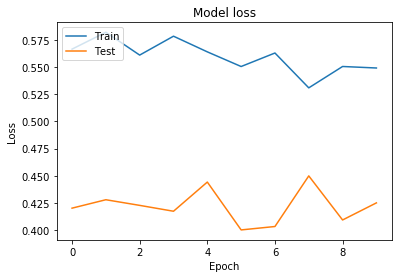

Saved model to disk
fold: 3
train_dir: /home/jupyter/kfold/3/train
val_dir: /home/jupyter/kfold/3/validation
Found 5745 images belonging to 25 classes.
Found 1435 images belonging to 25 classes.
Epoch 1/10
89/89 [==============================] - 698s 8s/step - loss: 0.5541 - categorical_accuracy: 0.8513 - val_loss: 0.4151 - val_categorical_accuracy: 0.8707
Epoch 2/10
89/89 [==============================] - 411s 5s/step - loss: 0.5406 - categorical_accuracy: 0.8505 - val_loss: 0.4134 - val_categorical_accuracy: 0.8738
Epoch 3/10
89/89 [==============================] - 405s 5s/step - loss: 0.5393 - categorical_accuracy: 0.8549 - val_loss: 0.4218 - val_categorical_accuracy: 0.8665
Epoch 4/10
89/89 [==============================] - 402s 5s/step - loss: 0.5156 - categorical_accuracy: 0.8564 - val_loss: 0.4188 - val_categorical_accuracy: 0.8782
Epoch 5/10
89/89 [==============================] - 410s 5s/step - loss: 0.5122 - categorical_accuracy: 0.8574 - val_loss: 0.4262 - val_categoric

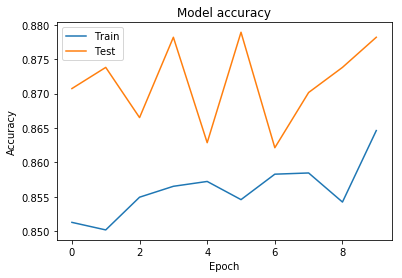

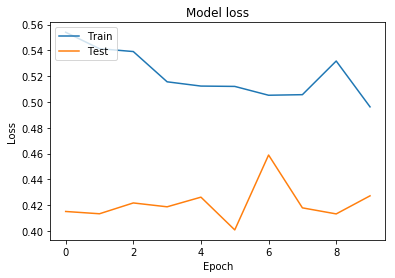

Saved model to disk
fold: 4
train_dir: /home/jupyter/kfold/4/train
val_dir: /home/jupyter/kfold/4/validation
Found 5742 images belonging to 25 classes.
Found 1435 images belonging to 25 classes.
Epoch 1/10
89/89 [==============================] - 691s 8s/step - loss: 0.5047 - categorical_accuracy: 0.8641 - val_loss: 0.3451 - val_categorical_accuracy: 0.8871
Epoch 2/10
89/89 [==============================] - 404s 5s/step - loss: 0.4892 - categorical_accuracy: 0.8604 - val_loss: 0.3329 - val_categorical_accuracy: 0.8877
Epoch 3/10
89/89 [==============================] - 400s 4s/step - loss: 0.4897 - categorical_accuracy: 0.8583 - val_loss: 0.3410 - val_categorical_accuracy: 0.8833
Epoch 4/10
89/89 [==============================] - 404s 5s/step - loss: 0.4948 - categorical_accuracy: 0.8612 - val_loss: 0.3274 - val_categorical_accuracy: 0.8928
Epoch 5/10
89/89 [==============================] - 404s 5s/step - loss: 0.4688 - categorical_accuracy: 0.8637 - val_loss: 0.3446 - val_categoric

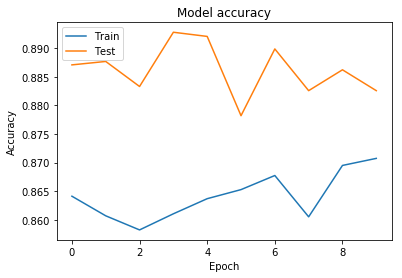

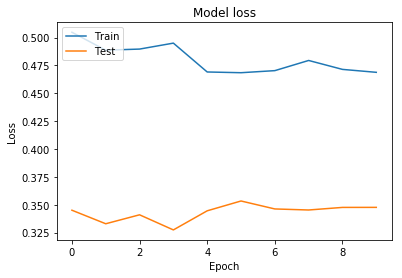

Saved model to disk
Saved model to disk


In [12]:
# == TRAINING ==
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-6), # leave it as is
              metrics=['categorical_accuracy'])

# Serialize model to JSON
model_json = model.to_json()
with open('./models/picnic_model_v4.json', 'w') as json_file:
    json_file.write(model_json)
    
for fold, (train_dir, val_dir) in zip(range(k), train_val_dirs):
    if fold < 1:
        continue
    print('fold: {}'.format(fold))
    print('train_dir: {}'.format(train_dir))
    print('val_dir: {}'.format(val_dir))

    train_datagen = ImageDataGenerator( # handle vectorization
        rescale=1./255, # normalize pixel values
        rotation_range=80,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    # rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
    # width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
    # shear_range is for randomly applying shearing transformations.
    # zoom_range is for randomly zooming inside pictures.
    # horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
    # fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

    train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(299, 299),
                batch_size=batch_size,
                class_mode='categorical')

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
                val_dir,
                target_size=(299, 299),
                batch_size=batch_size,
                class_mode='categorical')

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=(samples_in_fold*(k - 1))//batch_size,
                                  epochs=10,
                                  validation_data=validation_generator,
                                  validation_steps=(samples_in_fold)//batch_size)
    plot(history)

    # Serialize weights to HDF5
    model.save_weights('./models/picnic_model_' + str(fold) + '_v4.h5')
    print('Saved model to disk')


# Serialize weights to HDF5
model.save_weights('./models/picnic_model_v4.h5')
print('Saved model to disk')